## Notebook Purpose
This notebook is used to plot bin-wise Lagrangian SMB profile with respect to debris thickness and elevation (Supplementary Figure 6).

#### Last updated: May, 2023

## TODO:
- Update imports when new library has been built up with all updates
-Generalise path to data products during revisions, after the data distribution plan is finalized


In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'


In [2]:
import numpy as np 
import geopandas as gpd
import matplotlib.pyplot as plt
from imview import pltlib
import pandas as pd
from pygeotools.lib import warplib,geolib,iolib,malib,filtlib,timelib
import os,sys,glob,shutil
from debris_cover_smb import glac_dyn, constants,geospatial
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline


## Test with Khumbu Glacier

In [4]:
%cd /nobackup/sbhusha1/chapter2/HighresDebrisCover_SMB_Data/

/nobackupp11/sbhusha1/chapter2/HighresDebrisCover_SMB_Data


In [5]:
lirung_df = pd.read_csv('Lirung/SMB_data/lirung_farinotti_2016-11-06_to_2017-12-22_altitudnal_meltstats.csv')

lirung_df = pd.read_csv('/nobackup/deshean/ps_velocity/changrinup/demdir/aligned/hillshades/khumbu_farinotti_2015-11-02_to_2016-10-25_lag_smb_products/khumbu_farinotti_2015-11-02_to_2016-10-25_altitudnal_meltstats.csv')

In [6]:
def boxplot_stats_aggregator(df):
    debris_boxes_list_nowhisker = []    
    for idx,rows in df.iterrows():

        debris_box_temp = {
                'label':rows['z_bin_centers'],
                'positions':rows['z_bin_centers'],
                'whislo':rows['q1_deb_thick'],
                'q1':rows['q1_deb_thick'],
                'med':rows['med_deb_thick'],
                'q3':rows['q3_deb_thick'],
                'whishi':rows['q3_deb_thick'],
                'fliers':[]
            }
        debris_boxes_list_nowhisker.append(debris_box_temp)
    return debris_boxes_list_nowhisker

In [7]:
debris_box_plot = boxplot_stats_aggregator(lirung_df)

In [8]:
lirung_df.keys()

Index(['med_bg_dhdt', 'nmad_bg_dhdt', 'q1_bg_dhdt', 'q3_bg_dhdt', 'area_bg',
       'med_hotspot_dhdt', 'nmad_hotspot_dhdt', 'q1_hotspot_dhdt',
       'q3_hotspot_dhdt', 'area_hotspot', 'med_clean_dhdt', 'nmad_clean_dhdt',
       'q1_clean_dhdt', 'q3_clean_dhdt', 'area_clean', 'med_total_dhdt',
       'nmad_total_dhdt', 'q1_total_dhdt', 'q3_total_dhdt', 'area_total',
       'med_deb_thick', 'nmad_deb_thick', 'q1_deb_thick', 'q3_deb_thick',
       'med_deb_melt_enhancement', 'q1_deb_melt_enhancement',
       'q3_deb_melt_enhancemente ', 'med_vm', 'nmad_vm', 'q1_vm', 'q3_vm',
       'z_area', 'z_bin_centers', 'smb_error_mean', 'smb_error_med'],
      dtype='object')

In [9]:
(lirung_df['area_total']*lirung_df['med_total_dhdt']).sum()/(lirung_df['area_total'].sum())

-1.811695464226353

In [10]:
melt_df = lirung_df

In [11]:
melt_df.keys()

Index(['med_bg_dhdt', 'nmad_bg_dhdt', 'q1_bg_dhdt', 'q3_bg_dhdt', 'area_bg',
       'med_hotspot_dhdt', 'nmad_hotspot_dhdt', 'q1_hotspot_dhdt',
       'q3_hotspot_dhdt', 'area_hotspot', 'med_clean_dhdt', 'nmad_clean_dhdt',
       'q1_clean_dhdt', 'q3_clean_dhdt', 'area_clean', 'med_total_dhdt',
       'nmad_total_dhdt', 'q1_total_dhdt', 'q3_total_dhdt', 'area_total',
       'med_deb_thick', 'nmad_deb_thick', 'q1_deb_thick', 'q3_deb_thick',
       'med_deb_melt_enhancement', 'q1_deb_melt_enhancement',
       'q3_deb_melt_enhancemente ', 'med_vm', 'nmad_vm', 'q1_vm', 'q3_vm',
       'z_area', 'z_bin_centers', 'smb_error_mean', 'smb_error_med'],
      dtype='object')

In [19]:
def plot_glacier_meltcurve(melt_df,debris_box_plot,title,ylim,xlim,log_scale=False,set_deb_area_lim=False):
    f,ax = plt.subplots(3,1,sharex=True,figsize=(5,5),gridspec_kw={"height_ratios":[2.5,1.5,1]})
    area_wt_mb = (melt_df['area_total']*melt_df['med_total_dhdt']).sum()/(melt_df['area_total'].sum())
    mb_text = f"{np.round(area_wt_mb,2)} m/yr"
    t = ax[0].text(0.70,0.15,mb_text,
    color='red', fontsize=12,transform=ax[0].transAxes)
    #ax2=ax[0].twinx()
    #ax2.bar(melt_df.z_bin_centers,melt_df.area_total,color='brown',width=100)
    ax[0].plot(melt_df.z_bin_centers,melt_df.med_total_dhdt,color='red')
    ax[0].fill_between(melt_df.z_bin_centers,melt_df.med_total_dhdt-melt_df.smb_error_med,
                    melt_df.med_total_dhdt+melt_df.smb_error_med,color='red',alpha=0.5)
    
    ax[0].set_title(title)
    #ax.set_xlabel('Elevation (m)')

    ax[0].set_ylabel(r'$\frac{\dot{b}}{\rho}\;(m/yr)$ ')
    
    ax[0].axhline(0,linestyle='--',c='k')

    c = 'brown'
    debris_box_p = ax[1].bxp(debris_box_plot,showfliers=False,positions=melt_df.z_bin_centers.values,widths=50,
                            patch_artist=True)
    plt.setp(debris_box_p['boxes'], color='k')
    plt.setp(debris_box_p['medians'], color='k')
    plt.setp(debris_box_p["boxes"], facecolor=c)
    #for idx in range(len(debris_box_p['boxes'])):
     #   boxes.set(facecolor='gray')
    
    ax[1].set_xticks(np.arange(xlim[0],xlim[1],400))
    
    ax[1].set_xticklabels(np.arange(xlim[0],xlim[1],400))
    #ax[1].set_yscale('log')
    ax[1].set_ylabel(r'$Deb.\:thick.\:(m)$ ')

    ax[2].bar(melt_df.z_bin_centers,melt_df.area_total,width=50,color='gray',edgecolor='black')
    ax[2].set_ylabel(r'$Area\:(km^2)$ ')
    ax[2].set_xlabel(r'$Elevation\:(m)$ ')
    ax[2].set_xlim(xlim)

    if log_scale:
        #ax[0].set_yscale('log')
        ax[1].set_yscale('log')
        ax[2].set_yscale('log')
        if set_deb_area_lim:
            ax[1].set_ylim(0.00013055020014235964,4.038171275475809)
            ax[2].set_ylim(0.0011124606311300202,3.2126363799438398)
        
    else:
        if set_deb_area_lim:
            ax[1].set_ylim(0,4.038171275475809)
            ax[2].set_ylim(0,3.2126363799438398)
    ax[1].minorticks_on()
    ax[2].minorticks_on()
    ax[0].minorticks_on()
    ax[0].set_ylim(ylim)
    #t = ax[0].text(9.511123864139545e-05,0.92,'(i)',
    #color='black', fontsize=10,transform=ax[0].transAxes)
    #t.set_bbox(dict(facecolor='gray', alpha=1, edgecolor='gray'))
    #t = ax[1].text(0.020,0.86,'(ii)',
    #color='black', fontsize=10,transform=ax[1].transAxes)
    #t.set_bbox(dict(facecolor='gray', alpha=1, edgecolor='gray'))
    #t = ax[2].text(0.020,0.82,'(iii)',
    #color='black', fontsize=10,transform=ax[2].transAxes)
    #t.set_bbox(dict(facecolor='gray', alpha=1, edgecolor='gray'))
    plt.tight_layout()
    return f,ax

melt_df = pd.read_csv('Lirung/SMB_data/lirung_farinotti_2016-11-06_to_2017-12-22_altitudnal_meltstats.csv')
debris_box_plot = boxplot_stats_aggregator(melt_df)
old_title = 'A. 20161106 to 20171222'
title = 'A. Lirung Glacier'
f,ax = plot_glacier_meltcurve(melt_df,debris_box_plot,title,ylim=(-14,10),xlim=(3800,4601))
ax[0].plot(melt_df.z_bin_centers,melt_df.med_bg_dhdt,color='blue')
#f.savefig('figures/lirung_profile.png',dpi=300,bbox_inches='tight',pad_inches=0.1)
#plot_glacier_meltcurve(melt_df,debris_box_plot,'Lirung Glacier 2016-11-06 to 2017-12-22',ylim=(-14,10),xlim=(3900,4600))

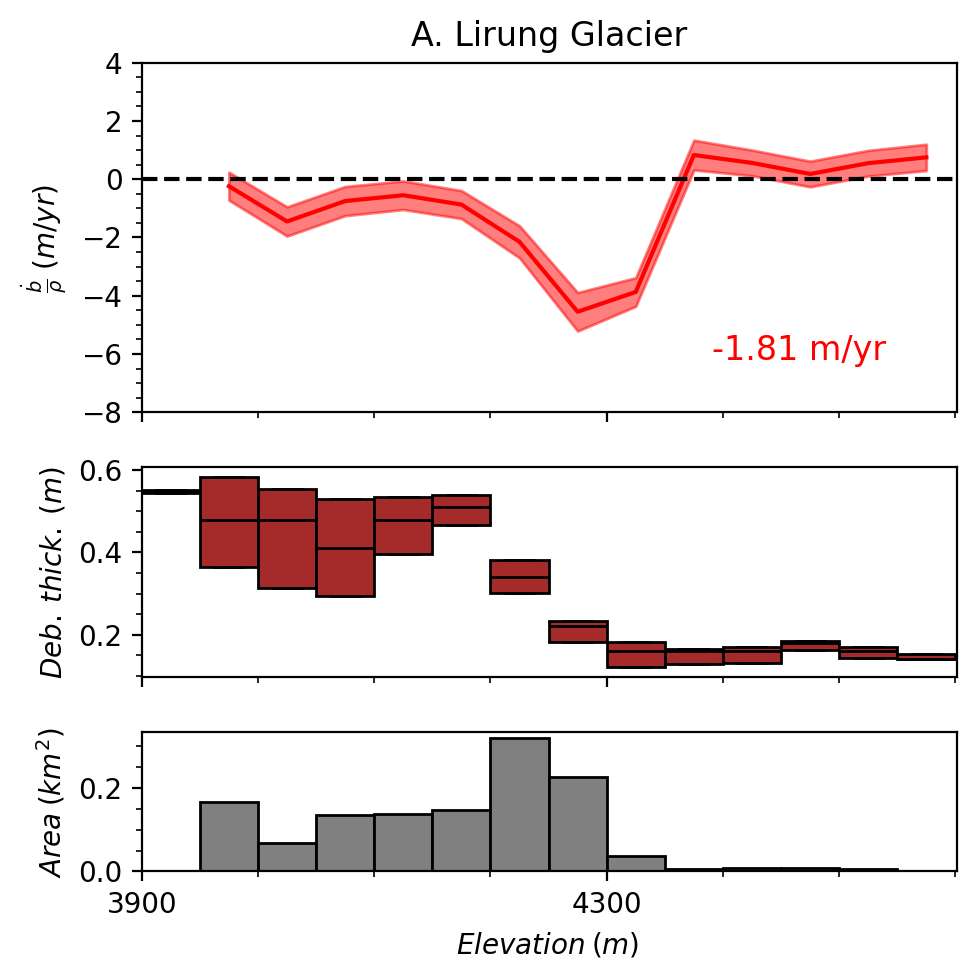

In [20]:
melt_df = pd.read_csv('Lirung/SMB_data/lirung_farinotti_2016-11-06_to_2017-12-22_altitudnal_meltstats.csv')
debris_box_plot = boxplot_stats_aggregator(melt_df)
old_title = 'A. 20161106 to 20171222'
title = 'A. Lirung Glacier'
f,ax = plot_glacier_meltcurve(melt_df,debris_box_plot,title,ylim=(-8,4),xlim=(3900,4601))
f.savefig('/nobackup/sbhusha1/chapter2/figures/lirung_profile_normal_scale_no_lim.png',dpi=300,bbox_inches='tight',pad_inches=0.1)
#plot_glacier_meltcurve(melt_df,debris_box_plot,'Lirung Glacier 2016-11-06 to 2017-12-22',ylim=(-14,10),xlim=(3900,4600))

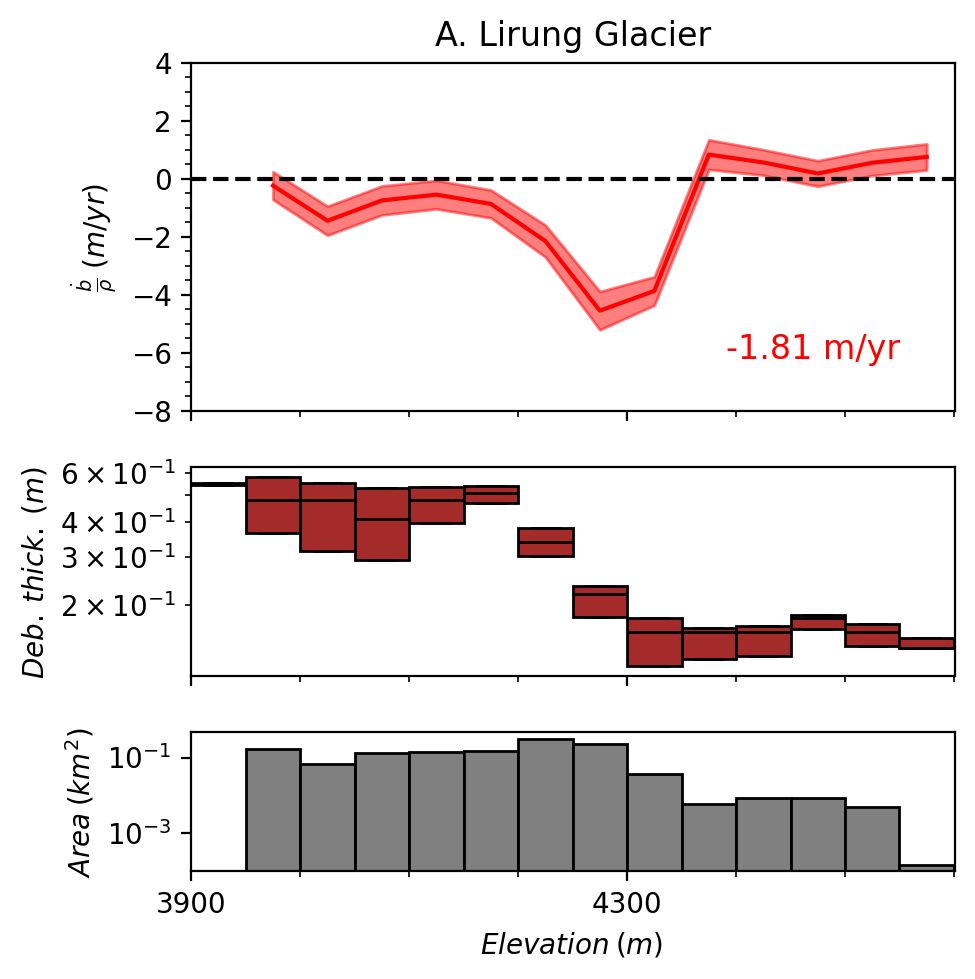

In [21]:
melt_df = pd.read_csv('Lirung/SMB_data/lirung_farinotti_2016-11-06_to_2017-12-22_altitudnal_meltstats.csv')
debris_box_plot = boxplot_stats_aggregator(melt_df)
old_title = 'A. 20161106 to 20171222'
title = 'A. Lirung Glacier'
f,ax = plot_glacier_meltcurve(melt_df,debris_box_plot,title,ylim=(-8,4),xlim=(3900,4601),log_scale=True)
f.savefig('/nobackup/sbhusha1/chapter2/figures/lirung_profile_log_scale_no_lim.png',dpi=300,bbox_inches='tight',pad_inches=0.1)
#plot_glacier_meltcurve(melt_df,debris_box_plot,'Lirung Glacier 2016-11-06 to 2017-12-22',ylim=(-14,10),xlim=(3900,4600))

(0.0011124606311300202, 3.2126363799438398)
(0.00013055020014235964, 4.038171275475809)


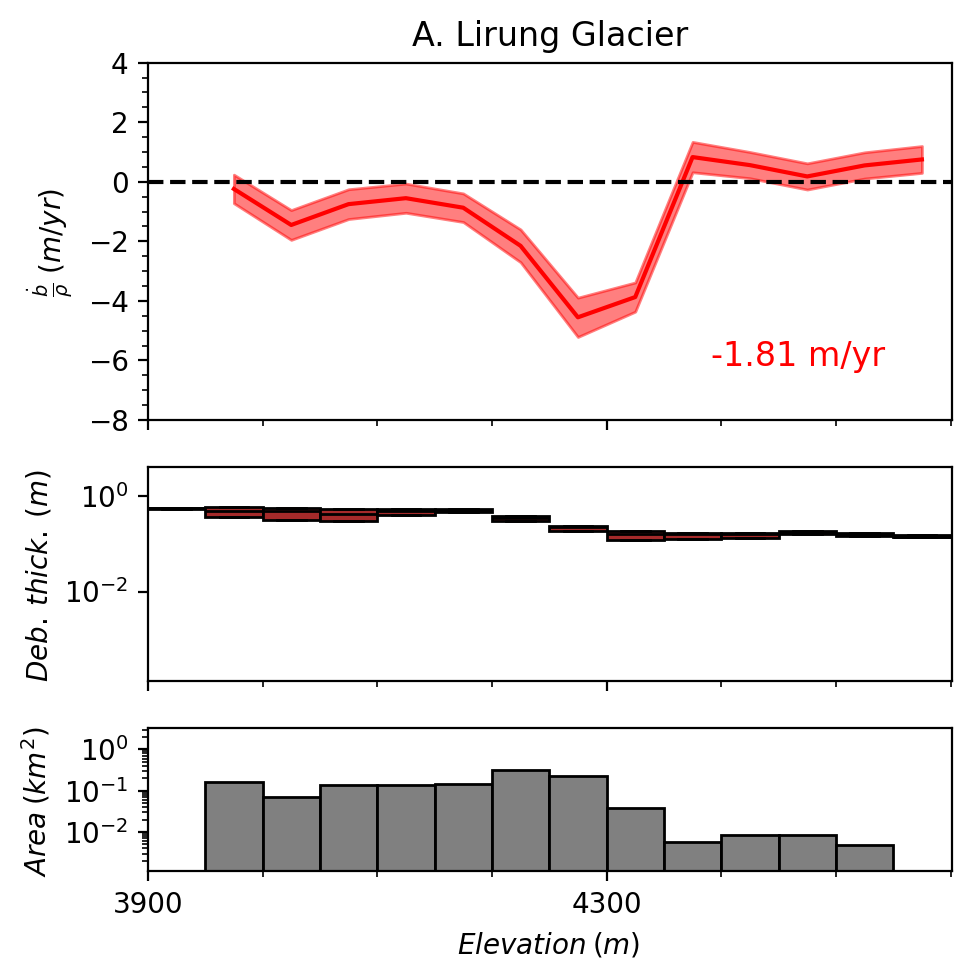

In [22]:
melt_df = pd.read_csv('Lirung/SMB_data/lirung_farinotti_2016-11-06_to_2017-12-22_altitudnal_meltstats.csv')
debris_box_plot = boxplot_stats_aggregator(melt_df)
old_title = 'A. 20161106 to 20171222'
title = 'A. Lirung Glacier'
f,ax = plot_glacier_meltcurve(melt_df,debris_box_plot,title,ylim=(-8,4),xlim=(3900,4601),log_scale=True,set_deb_area_lim=True)
print(ax[2].get_ylim())
print(ax[1].get_ylim())
f.savefig('/nobackup/sbhusha1/chapter2/figures/lirung_profile_log_scale_common_lim.png',dpi=300,bbox_inches='tight',pad_inches=0.1)
#plot_glacier_meltcurve(melt_df,debris_box_plot,'Lirung Glacier 2016-11-06 to 2017-12-22',ylim=(-14,10),xlim=(3900,4600))

## Langtang Glacier

(0.0, 1.5837989999999997)
(-0.14173884170595563, 3.1496066115098076)


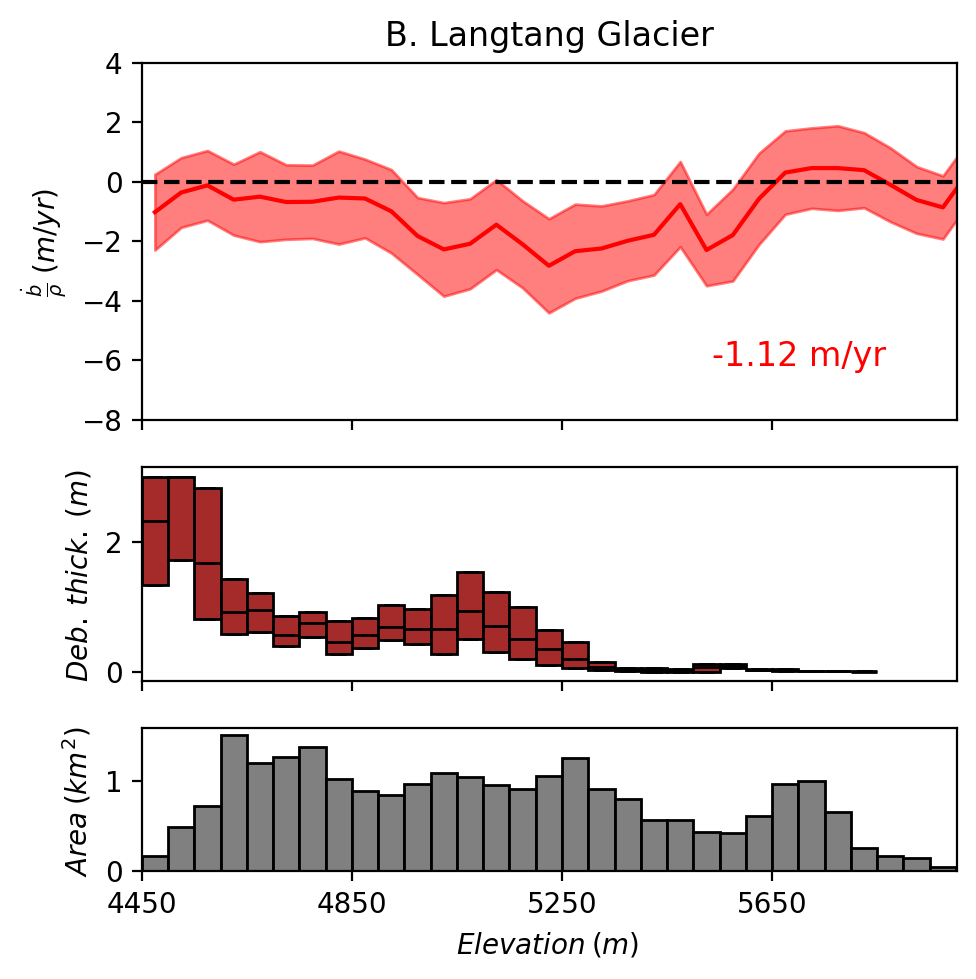

In [100]:
#melt_df = pd.read_csv(sorted(glob.glob('/nobackup/deshean/ps_velocity/langtang/dem_dir/aligned_dems/hillshades/langtang_farinotti_2015-02-22_to_2016-01-07_lag_smb_products/langtang_f*melt*.csv'))[0])
melt_df = pd.read_csv('Langtang/SMB_data/langtang_farinotti_2015-02-22_to_2016-01-07_altitudnal_meltstats.csv')
debris_box_plot = boxplot_stats_aggregator(melt_df)
old_title = 'Langtang Glacier 2015-02-22 to 2016-01-07'
title = 'B. Langtang Glacier'
#plot_glacier_meltcurve(melt_df,debris_box_plot,,ylim=(-14,10),xlim=)
f,ax = plot_glacier_meltcurve(melt_df,debris_box_plot,title,ylim=(-8,4),xlim=(4450,6001))
print(ax[2].get_ylim())
print(ax[1].get_ylim())
f.savefig('/nobackup/sbhusha1/chapter2/figures/langtang_profile_normal_scale_common_lim.png',dpi=300,bbox_inches='tight',pad_inches=0.1)

(0.0, 1.5837989999999997)
(-0.14173884170595563, 3.1496066115098076)


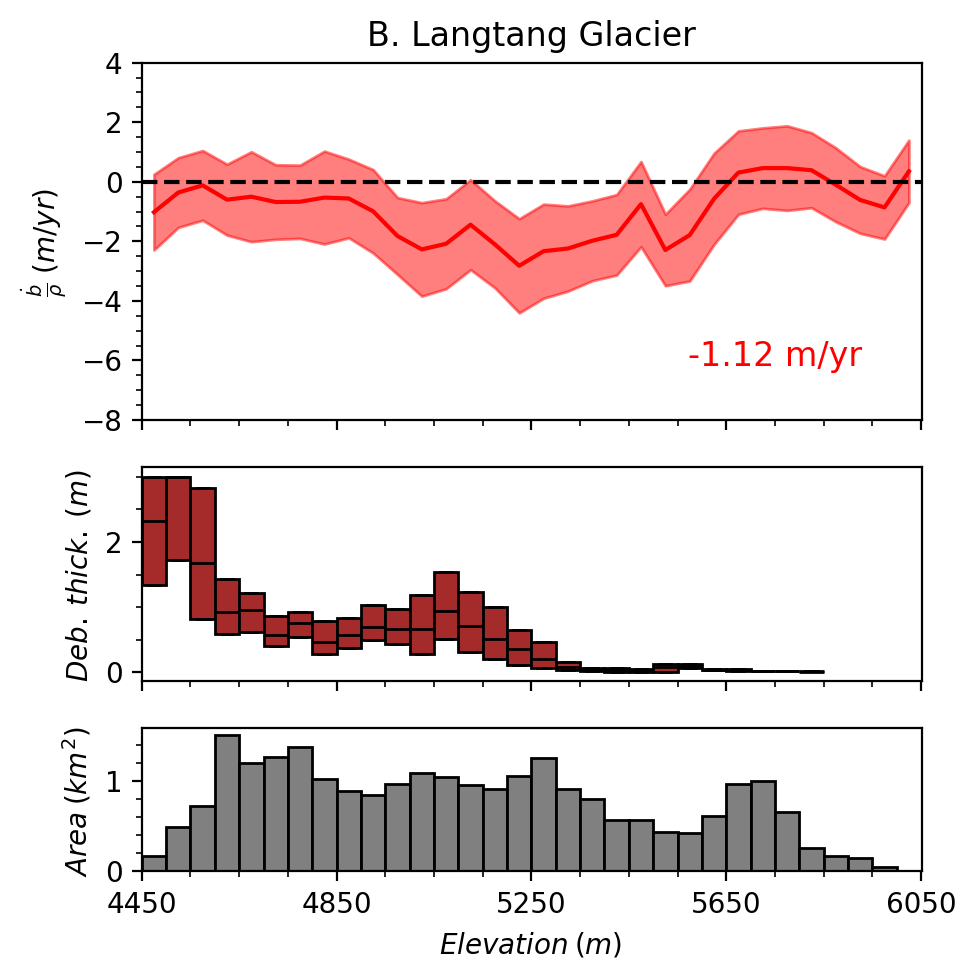

In [23]:
#melt_df = pd.read_csv(sorted(glob.glob('/nobackup/deshean/ps_velocity/langtang/dem_dir/aligned_dems/hillshades/langtang_farinotti_2015-02-22_to_2016-01-07_lag_smb_products/langtang_f*melt*.csv'))[0])
melt_df = pd.read_csv('Langtang/SMB_data/langtang_farinotti_2015-02-22_to_2016-01-07_altitudnal_meltstats.csv')
debris_box_plot = boxplot_stats_aggregator(melt_df)
old_title = 'Langtang Glacier 2015-02-22 to 2016-01-07'
title = 'B. Langtang Glacier'
#plot_glacier_meltcurve(melt_df,debris_box_plot,,ylim=(-14,10),xlim=)
f,ax = plot_glacier_meltcurve(melt_df,debris_box_plot,title,ylim=(-8,4),xlim=(4450,6051))
print(ax[2].get_ylim())
print(ax[1].get_ylim())
f.savefig('/nobackup/sbhusha1/chapter2/figures/langtang_profile_normal_scale_no_lim.png',dpi=300,bbox_inches='tight',pad_inches=0.1)

(0.0011124606311300202, 3.2126363799438398)
(0.00013055020014235964, 4.038171275475809)


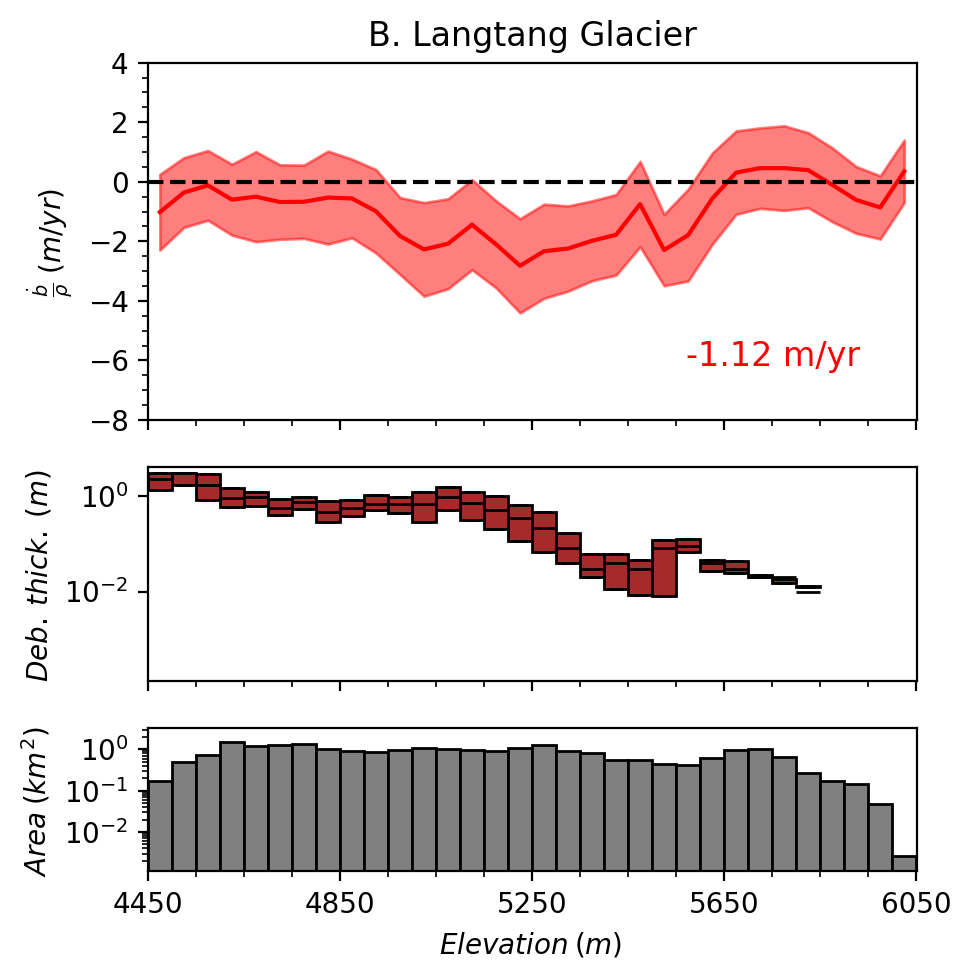

In [24]:
#melt_df = pd.read_csv(sorted(glob.glob('/nobackup/deshean/ps_velocity/langtang/dem_dir/aligned_dems/hillshades/langtang_farinotti_2015-02-22_to_2016-01-07_lag_smb_products/langtang_f*melt*.csv'))[0])
melt_df = pd.read_csv('Langtang/SMB_data/langtang_farinotti_2015-02-22_to_2016-01-07_altitudnal_meltstats.csv')
debris_box_plot = boxplot_stats_aggregator(melt_df)
old_title = 'Langtang Glacier 2015-02-22 to 2016-01-07'
title = 'B. Langtang Glacier'
#plot_glacier_meltcurve(melt_df,debris_box_plot,,ylim=(-14,10),xlim=)
f,ax = plot_glacier_meltcurve(melt_df,debris_box_plot,title,ylim=(-8,4),xlim=(4450,6051),log_scale=True,set_deb_area_lim=True)
print(ax[2].get_ylim())
print(ax[1].get_ylim())
f.savefig('/nobackup/sbhusha1/chapter2/figures/langtang_profile_log_scale_common_lim.png',dpi=300,bbox_inches='tight',pad_inches=0.1)

(0.0019464925158757672, 2.0705917578042383)
(0.005845049107971343, 4.038171275475809)


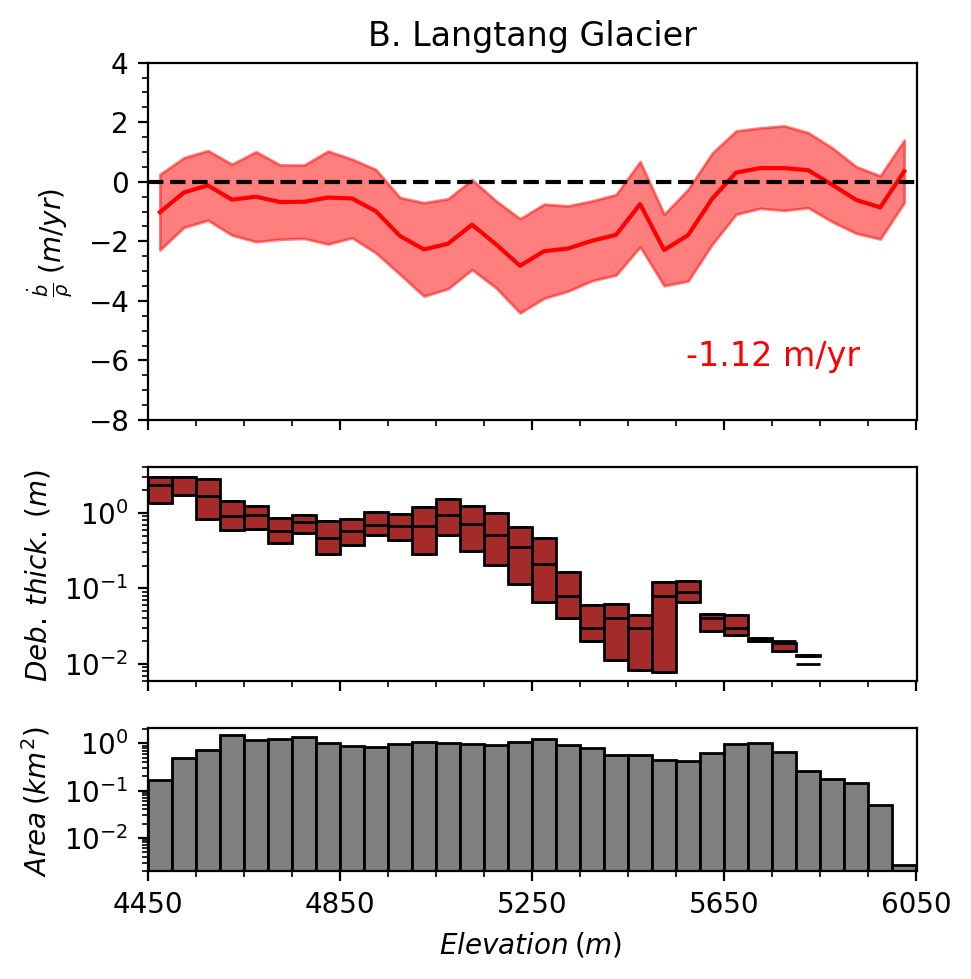

In [25]:
#melt_df = pd.read_csv(sorted(glob.glob('/nobackup/deshean/ps_velocity/langtang/dem_dir/aligned_dems/hillshades/langtang_farinotti_2015-02-22_to_2016-01-07_lag_smb_products/langtang_f*melt*.csv'))[0])
melt_df = pd.read_csv('Langtang/SMB_data/langtang_farinotti_2015-02-22_to_2016-01-07_altitudnal_meltstats.csv')
debris_box_plot = boxplot_stats_aggregator(melt_df)
old_title = 'Langtang Glacier 2015-02-22 to 2016-01-07'
title = 'B. Langtang Glacier'
#plot_glacier_meltcurve(melt_df,debris_box_plot,,ylim=(-14,10),xlim=)
f,ax = plot_glacier_meltcurve(melt_df,debris_box_plot,title,ylim=(-8,4),xlim=(4450,6051),log_scale=True,set_deb_area_lim=False)
print(ax[2].get_ylim())
print(ax[1].get_ylim())
f.savefig('/nobackup/sbhusha1/chapter2/figures/langtang_profile_log_scale_no_lim.png',dpi=300,bbox_inches='tight',pad_inches=0.1)

## Ngozumpa

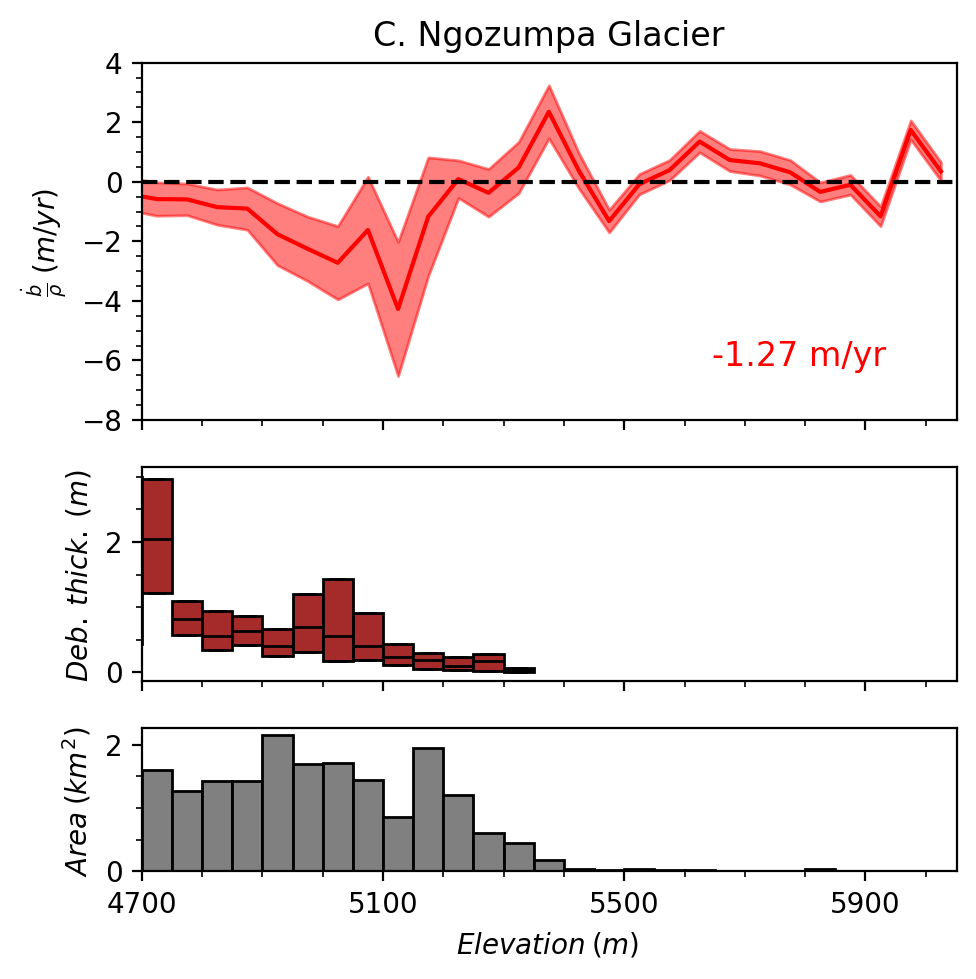

In [26]:
#melt_df = pd.read_csv('/nobackup/deshean/ps_velocity/ngozumpa/agu_1case/ngozumpa_farinotti_2012-12-23_to_2015-01-15_lag_smb_products/ngozumpa_farinotti_2012-12-23_to_2015-01-15_altitudnal_meltstats.csv')
melt_df = pd.read_csv('Ngozumpa/SMB_data/ngozumpa_farinotti_2012-12-23_to_2015-01-15_altitudnal_meltstats.csv')
debris_box_plot = boxplot_stats_aggregator(melt_df)
old_title = 'Ngozumpa Glacier 2012-12-23 to 2015-01-15'
title = 'C. Ngozumpa Glacier'
f,ax = plot_glacier_meltcurve(melt_df,debris_box_plot,title,ylim=(-8,4),xlim=(4700,6051))
f.savefig('/nobackup/sbhusha1/chapter2/figures/ngozumpa_profile_normal_scale_no_lim.png',dpi=300,bbox_inches='tight',pad_inches=0.1)


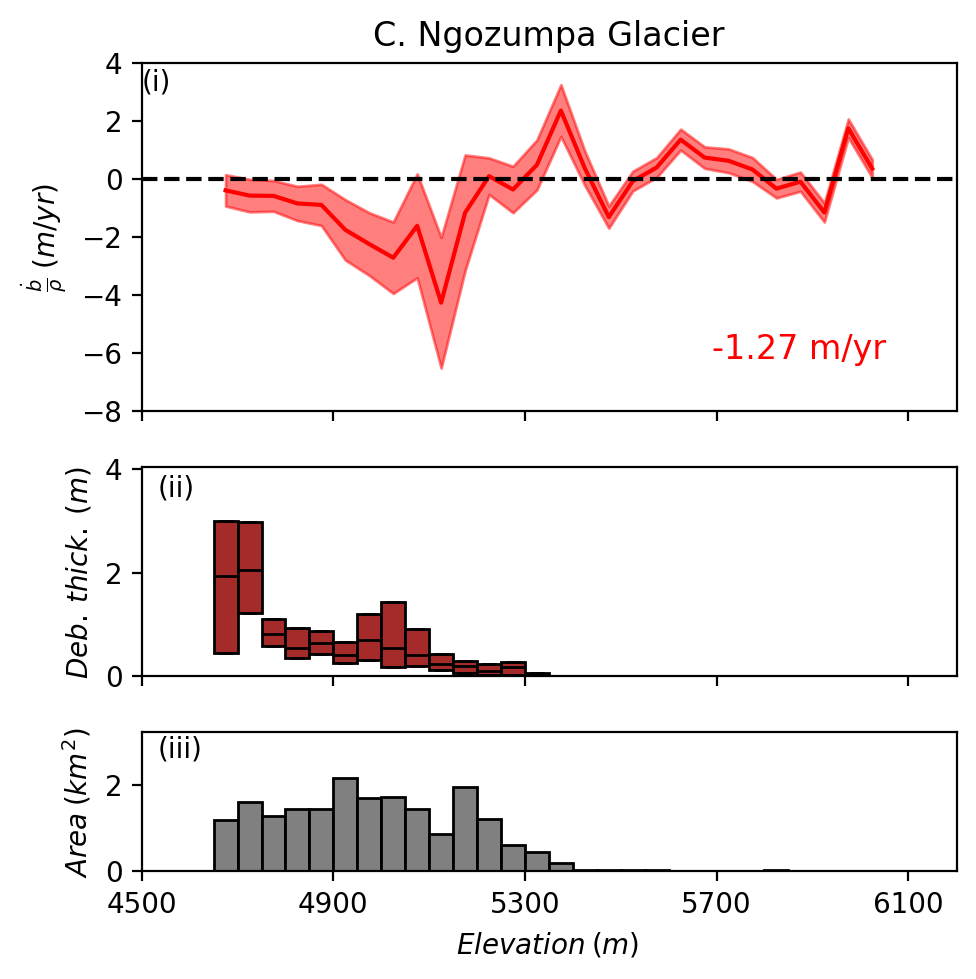

In [79]:
#melt_df = pd.read_csv('/nobackup/deshean/ps_velocity/ngozumpa/agu_1case/ngozumpa_farinotti_2012-12-23_to_2015-01-15_lag_smb_products/ngozumpa_farinotti_2012-12-23_to_2015-01-15_altitudnal_meltstats.csv')
melt_df = pd.read_csv('Ngozumpa/SMB_data/ngozumpa_farinotti_2012-12-23_to_2015-01-15_altitudnal_meltstats.csv')
debris_box_plot = boxplot_stats_aggregator(melt_df)
old_title = 'Ngozumpa Glacier 2012-12-23 to 2015-01-15'
title = 'C. Ngozumpa Glacier'
f,ax = plot_glacier_meltcurve(melt_df,debris_box_plot,title,ylim=(-8,4),xlim=(4500,6201),set_deb_area_lim=True)
f.savefig('/nobackup/sbhusha1/chapter2/figures/ngozumpa_profile_normal_scale_common_lim.png',dpi=300,bbox_inches='tight',pad_inches=0.1)


(0.00047132535803086096, 3.2126363799438398)
(0.00611640419472694, 4.028494042749692)


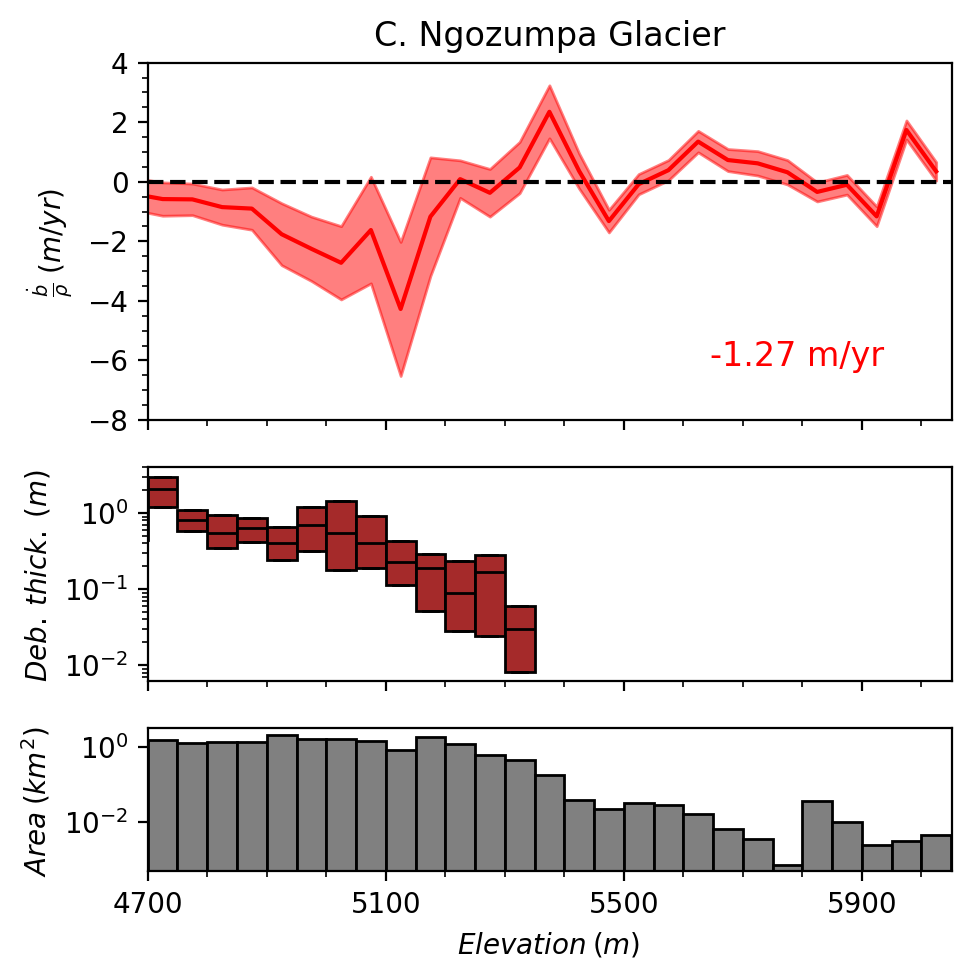

In [27]:
#melt_df = pd.read_csv('/nobackup/deshean/ps_velocity/ngozumpa/agu_1case/ngozumpa_farinotti_2012-12-23_to_2015-01-15_lag_smb_products/ngozumpa_farinotti_2012-12-23_to_2015-01-15_altitudnal_meltstats.csv')
melt_df = pd.read_csv('Ngozumpa/SMB_data/ngozumpa_farinotti_2012-12-23_to_2015-01-15_altitudnal_meltstats.csv')
debris_box_plot = boxplot_stats_aggregator(melt_df)
old_title = 'Ngozumpa Glacier 2012-12-23 to 2015-01-15'
title = 'C. Ngozumpa Glacier'
f,ax = plot_glacier_meltcurve(melt_df,debris_box_plot,title,ylim=(-8,4),xlim=(4700,6051),log_scale=True)
print(ax[2].get_ylim())
print(ax[1].get_ylim())
f.savefig('/nobackup/sbhusha1/chapter2/figures/ngozumpa_profile_log_scale_no_lim.png',dpi=300,bbox_inches='tight',pad_inches=0.1)

(0.0011124606311300202, 3.2126363799438398)
(0.00013055020014235964, 4.038171275475809)


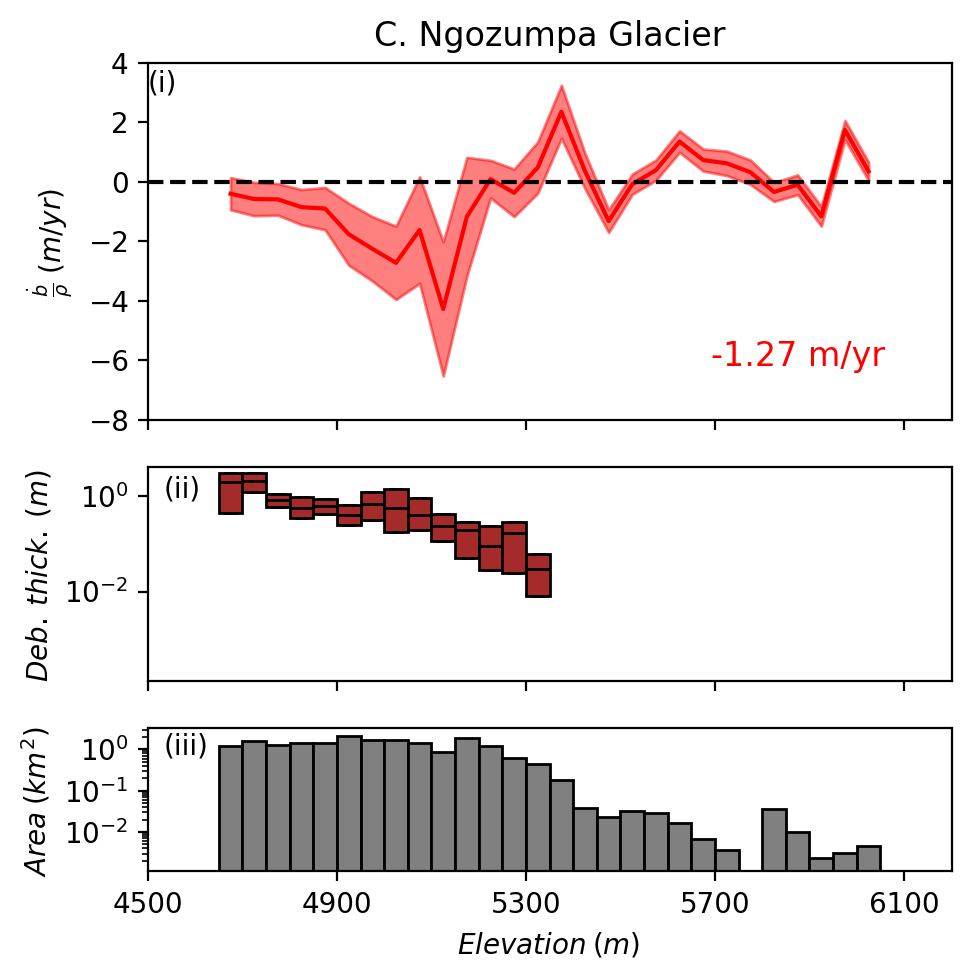

In [82]:
#melt_df = pd.read_csv('/nobackup/deshean/ps_velocity/ngozumpa/agu_1case/ngozumpa_farinotti_2012-12-23_to_2015-01-15_lag_smb_products/ngozumpa_farinotti_2012-12-23_to_2015-01-15_altitudnal_meltstats.csv')
melt_df = pd.read_csv('Ngozumpa/SMB_data/ngozumpa_farinotti_2012-12-23_to_2015-01-15_altitudnal_meltstats.csv')
debris_box_plot = boxplot_stats_aggregator(melt_df)
old_title = 'Ngozumpa Glacier 2012-12-23 to 2015-01-15'
title = 'C. Ngozumpa Glacier'
f,ax = plot_glacier_meltcurve(melt_df,debris_box_plot,title,ylim=(-8,4),xlim=(4500,6201),log_scale=True,set_deb_area_lim=True)
print(ax[2].get_ylim())
print(ax[1].get_ylim())
f.savefig('/nobackup/sbhusha1/chapter2/figures/ngozumpa_profile_log_scale_common_lim.png',dpi=300,bbox_inches='tight',pad_inches=0.1)

#melt_df = pd.read_csv('/nobackup/deshean/ps_velocity/ngozumpa/agu_1case/ngozumpa_farinotti_2012-12-23_to_2015-01-15_lag_smb_products/ngozumpa_farinotti_2012-12-23_to_2015-01-15_altitudnal_meltstats.csv')
melt_df = pd.read_csv('ngozumpa/20230217/ngozumpa_farinotti_2012-12-23_to_2015-01-15_lag_smb_products/ngozumpa_farinotti_2012-12-23_to_2015-01-15_altitudnal_meltstats.csv')
debris_box_plot = boxplot_stats_aggregator(melt_df)
old_title = 'Ngozumpa Glacier 2012-12-23 to 2015-01-15'
title = 'C. Ngozumpa Glacier'
f,ax = plot_glacier_meltcurve(melt_df,debris_box_plot,title,ylim=(-14,10),xlim=(4500,6201))
f.savefig('figures/ngozumpa_profile_log_scale.png',dpi=300,bbox_inches='tight',pad_inches=0.1)


## Black Changri Nup

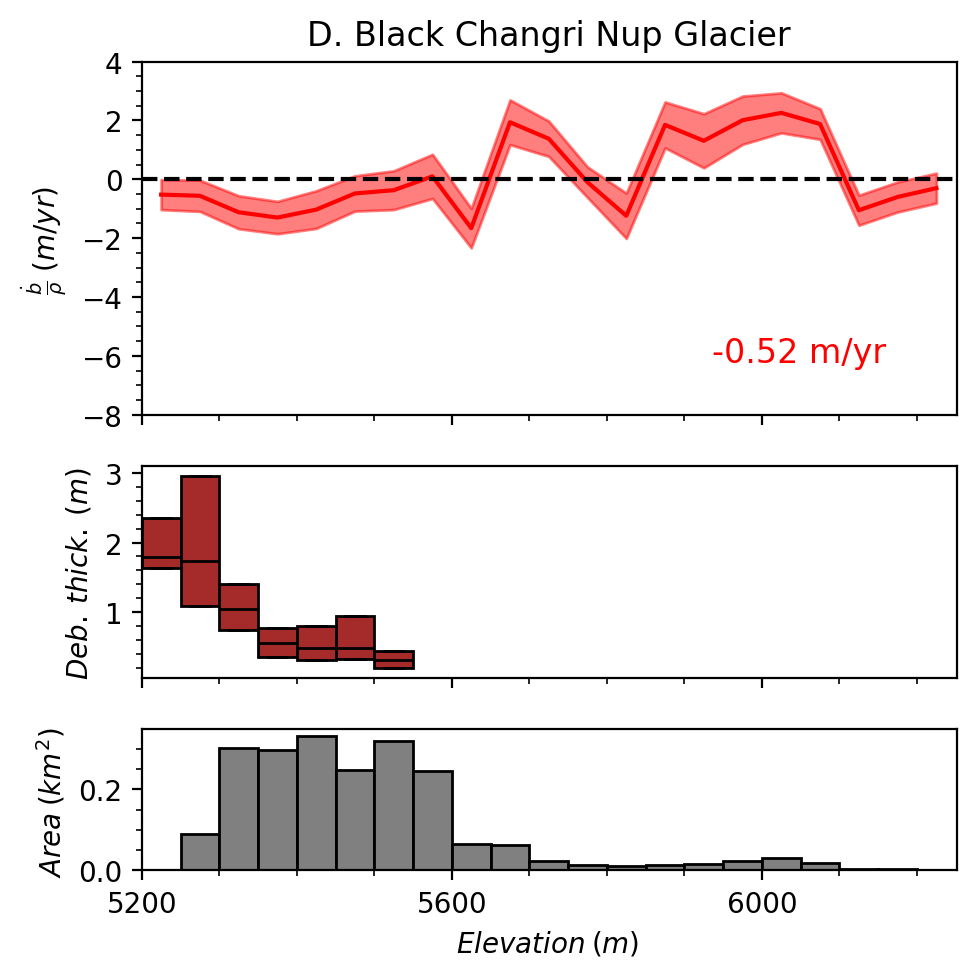

In [28]:
#melt_df = pd.read_csv('/nobackup/deshean/ps_velocity/changrinup/demdir/aligned/hillshades/black_changri_nup_farinotti_2015-11-02_to_2016-10-25_lag_smb_products/black_changri_nup_farinotti_2015-11-02_to_2016-10-25_altitudnal_meltstats.csv')
melt_df = pd.read_csv('BlackChangriNup/SMB_data/black_changri_nup_farinotti_2015-11-02_to_2016-10-25_altitudnal_meltstats.csv')
debris_box_plot = boxplot_stats_aggregator(melt_df)
#,ylim=(-14,10),xlim=)
old_title = 'Black Changri Nup Glacier 2015-11-02 to 2016-10-25'
title = 'D. Black Changri Nup Glacier'
f,ax = plot_glacier_meltcurve(melt_df,debris_box_plot,title,ylim=(-8,4),xlim=(5200,6251))
f.savefig('/nobackup/sbhusha1/chapter2/figures/black_changri_nup_profile_normal_scale_no_lim.png',dpi=300,bbox_inches='tight',pad_inches=0.1)


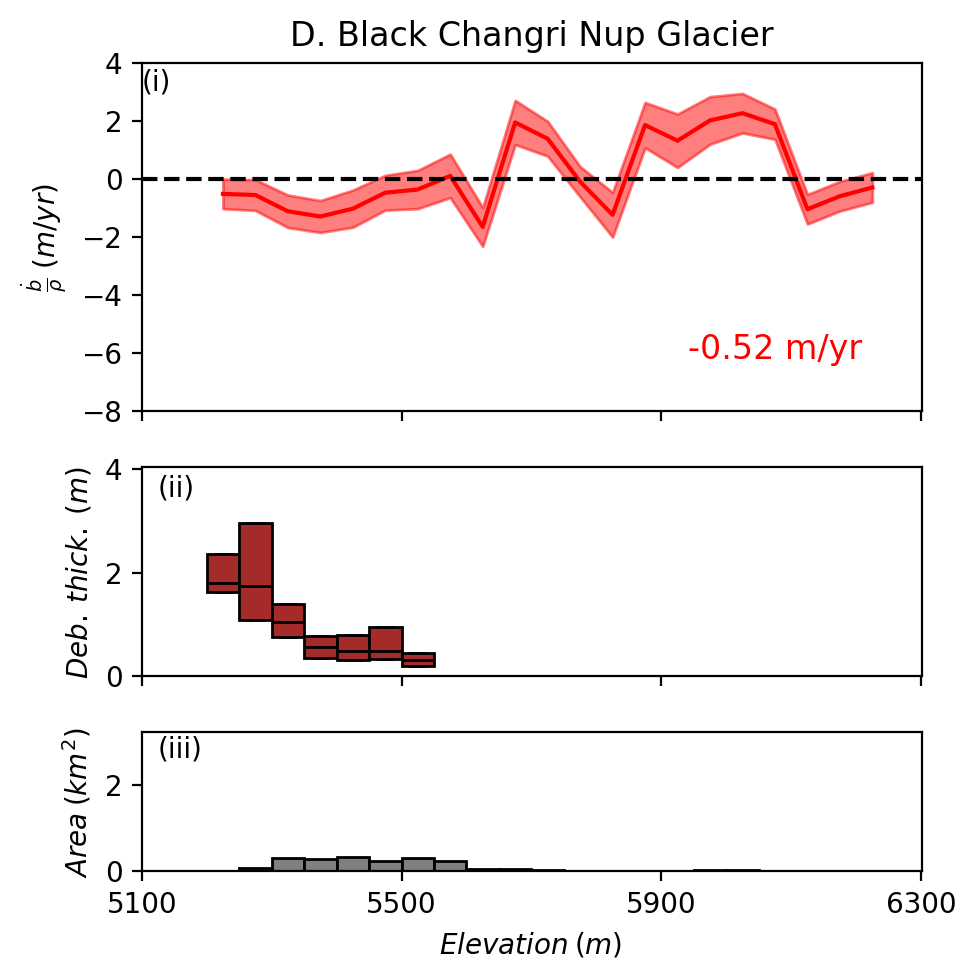

In [85]:
#melt_df = pd.read_csv('/nobackup/deshean/ps_velocity/changrinup/demdir/aligned/hillshades/black_changri_nup_farinotti_2015-11-02_to_2016-10-25_lag_smb_products/black_changri_nup_farinotti_2015-11-02_to_2016-10-25_altitudnal_meltstats.csv')
melt_df = pd.read_csv('BlackChangriNup/SMB_data/black_changri_nup_farinotti_2015-11-02_to_2016-10-25_altitudnal_meltstats.csv')
debris_box_plot = boxplot_stats_aggregator(melt_df)
#,ylim=(-14,10),xlim=)
old_title = 'Black Changri Nup Glacier 2015-11-02 to 2016-10-25'
title = 'D. Black Changri Nup Glacier'
f,ax = plot_glacier_meltcurve(melt_df,debris_box_plot,title,ylim=(-8,4),xlim=(5100,6301),set_deb_area_lim=True)
f.savefig('/nobackup/sbhusha1/chapter2/figures/black_changri_nup_profile_normal_scale_common_lim.png',dpi=300,bbox_inches='tight',pad_inches=0.1)


(0.0005082204548135489, 0.4521048096820417)
(0.1706822469105617, 3.3904677991478875)


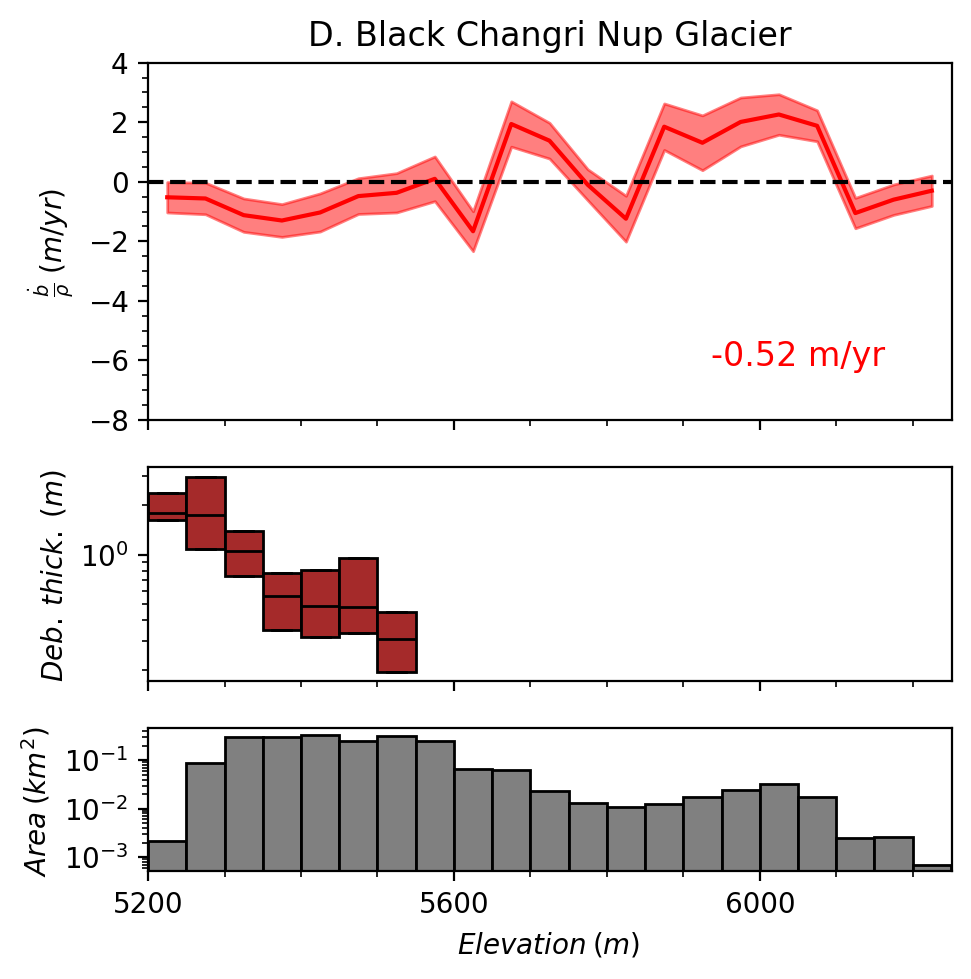

In [29]:
#melt_df = pd.read_csv('/nobackup/deshean/ps_velocity/changrinup/demdir/aligned/hillshades/black_changri_nup_farinotti_2015-11-02_to_2016-10-25_lag_smb_products/black_changri_nup_farinotti_2015-11-02_to_2016-10-25_altitudnal_meltstats.csv')
melt_df = pd.read_csv('BlackChangriNup/SMB_data/black_changri_nup_farinotti_2015-11-02_to_2016-10-25_altitudnal_meltstats.csv')
debris_box_plot = boxplot_stats_aggregator(melt_df)
#,ylim=(-14,10),xlim=)
old_title = 'Black Changri Nup Glacier 2015-11-02 to 2016-10-25'
title = 'D. Black Changri Nup Glacier'
f,ax = plot_glacier_meltcurve(melt_df,debris_box_plot,title,ylim=(-8,4),xlim=(5200,6251),log_scale=True)
print(ax[2].get_ylim())
print(ax[1].get_ylim())
f.savefig('/nobackup/sbhusha1/chapter2/figures/black_changri_nup_profile_log_scale_no_lim.png',dpi=300,bbox_inches='tight',pad_inches=0.1)


(0.0011124606311300202, 3.2126363799438398)
(0.00013055020014235964, 4.038171275475809)


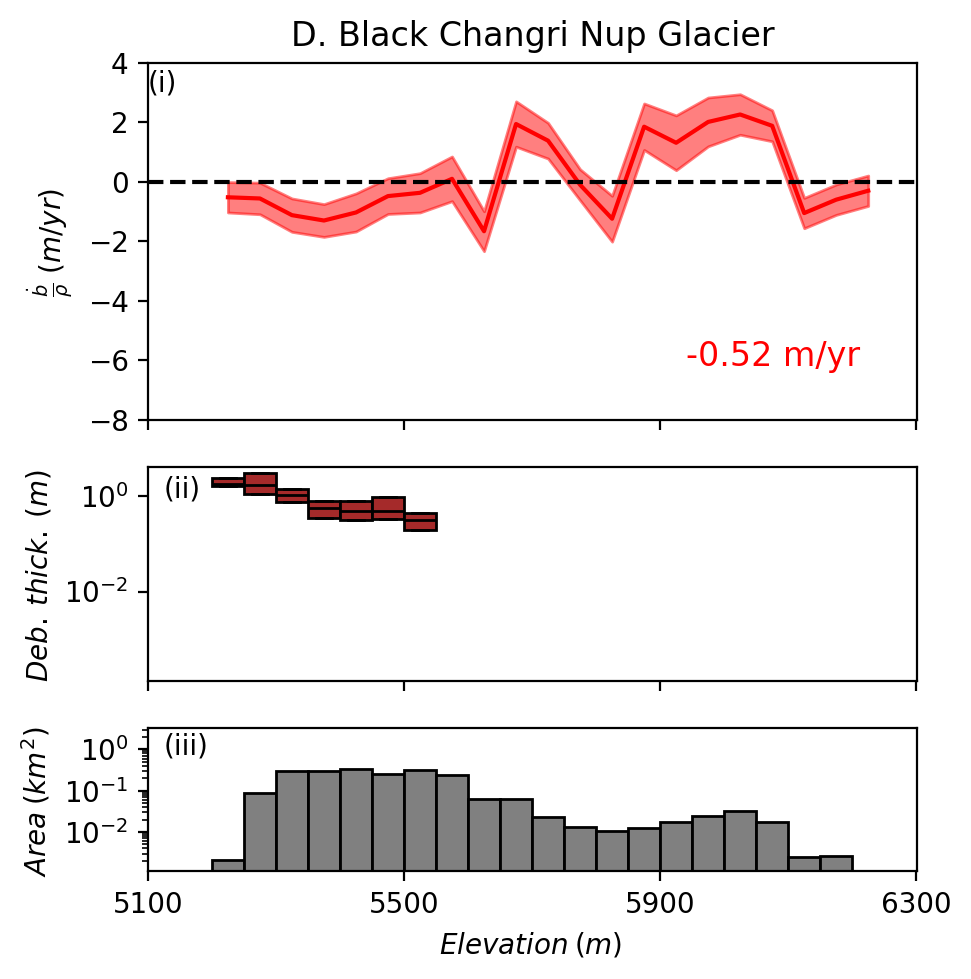

In [87]:
#melt_df = pd.read_csv('/nobackup/deshean/ps_velocity/changrinup/demdir/aligned/hillshades/black_changri_nup_farinotti_2015-11-02_to_2016-10-25_lag_smb_products/black_changri_nup_farinotti_2015-11-02_to_2016-10-25_altitudnal_meltstats.csv')
melt_df = pd.read_csv('BlackChangriNup/SMB_data/black_changri_nup_farinotti_2015-11-02_to_2016-10-25_altitudnal_meltstats.csv')
debris_box_plot = boxplot_stats_aggregator(melt_df)
#,ylim=(-14,10),xlim=)
old_title = 'Black Changri Nup Glacier 2015-11-02 to 2016-10-25'
title = 'D. Black Changri Nup Glacier'
f,ax = plot_glacier_meltcurve(melt_df,debris_box_plot,title,ylim=(-8,4),xlim=(5100,6301),log_scale=True,set_deb_area_lim=True)
print(ax[2].get_ylim())
print(ax[1].get_ylim())
f.savefig('/nobackup/sbhusha1/chapter2/figures/black_changri_nup_profile_log_scale_common_lim.png',dpi=300,bbox_inches='tight',pad_inches=0.1)


## Khumbu Glacier

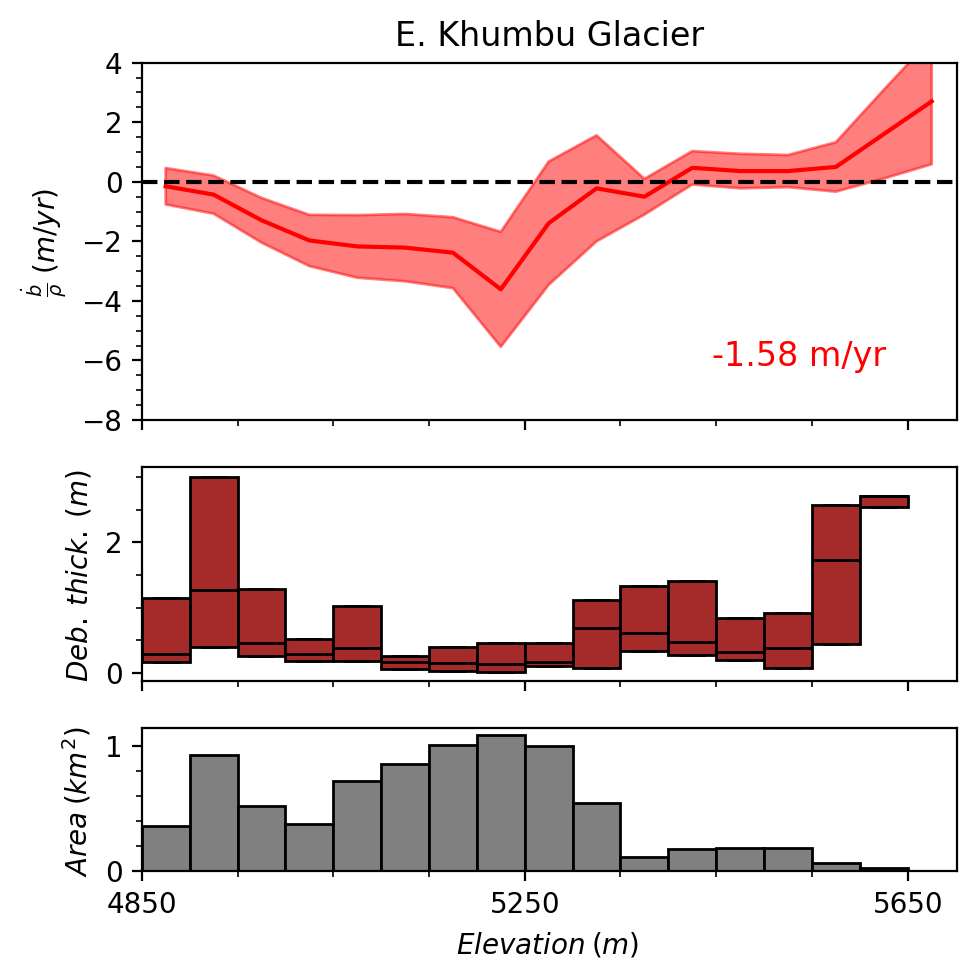

In [30]:
melt_df = pd.read_csv('Khumbu/SMB_data/khumbu_farinotti_2015-11-02_to_2016-10-25_altitudnal_meltstats.csv')
debris_box_plot = boxplot_stats_aggregator(melt_df)
#plot_glacier_meltcurve(melt_df,debris_box_plot,,ylim=(-14,10),xlim=(4800,5801))
old_title = 'Khumbu Glacier 2015-11-02 to 2016-10-25'
title = 'E. Khumbu Glacier'
f,ax = plot_glacier_meltcurve(melt_df,debris_box_plot,title,ylim=(-8,4),xlim=(4850,5701))
f.savefig('/nobackup/sbhusha1/chapter2/figures/khumbu_profile_normal_scale_no_lim.png',dpi=300,bbox_inches='tight',pad_inches=0.1)

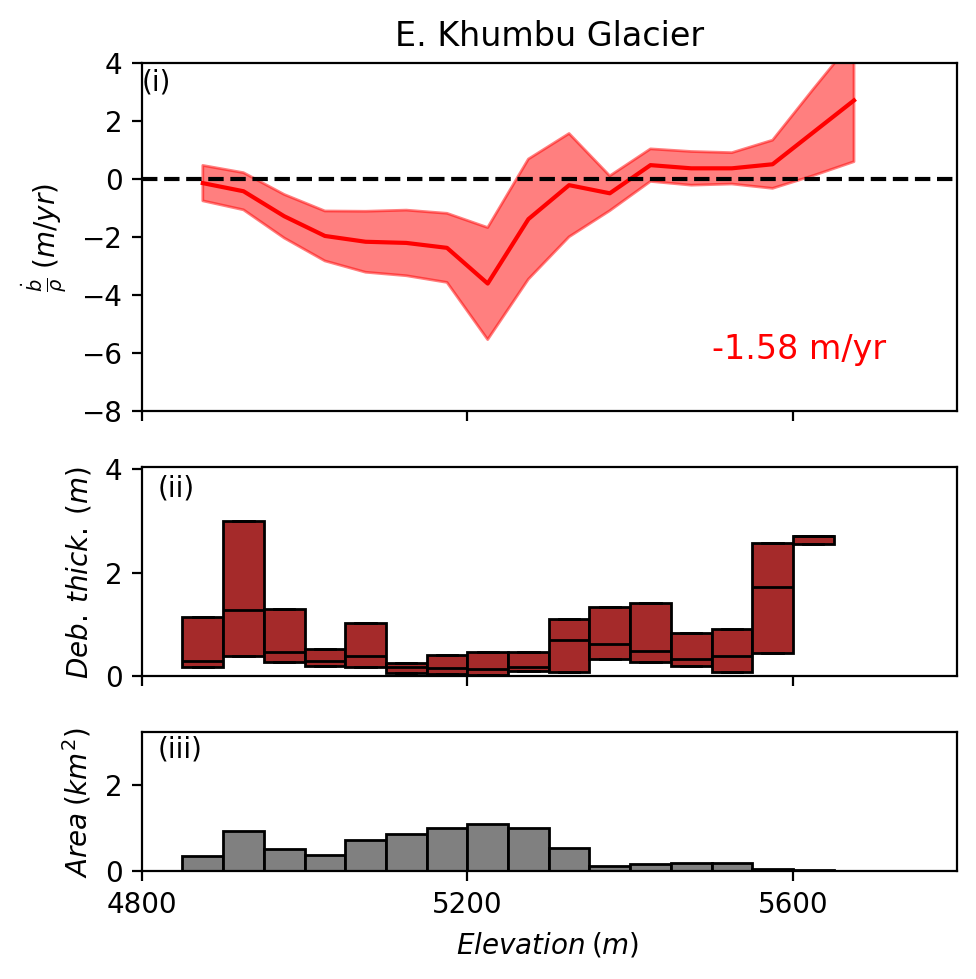

In [89]:
melt_df = pd.read_csv('Khumbu/SMB_data/khumbu_farinotti_2015-11-02_to_2016-10-25_altitudnal_meltstats.csv')
debris_box_plot = boxplot_stats_aggregator(melt_df)
#plot_glacier_meltcurve(melt_df,debris_box_plot,,ylim=(-14,10),xlim=(4800,5801))
old_title = 'Khumbu Glacier 2015-11-02 to 2016-10-25'
title = 'E. Khumbu Glacier'
f,ax = plot_glacier_meltcurve(melt_df,debris_box_plot,title,ylim=(-8,4),xlim=(4800,5801),set_deb_area_lim=True)
f.savefig('/nobackup/sbhusha1/chapter2/figures/khumbu_profile_normal_scale_common_lim.png',dpi=300,bbox_inches='tight',pad_inches=0.1)

(0.0011124606311300202, 1.5075191850128418)
(0.01721096951984333, 3.835752565689661)


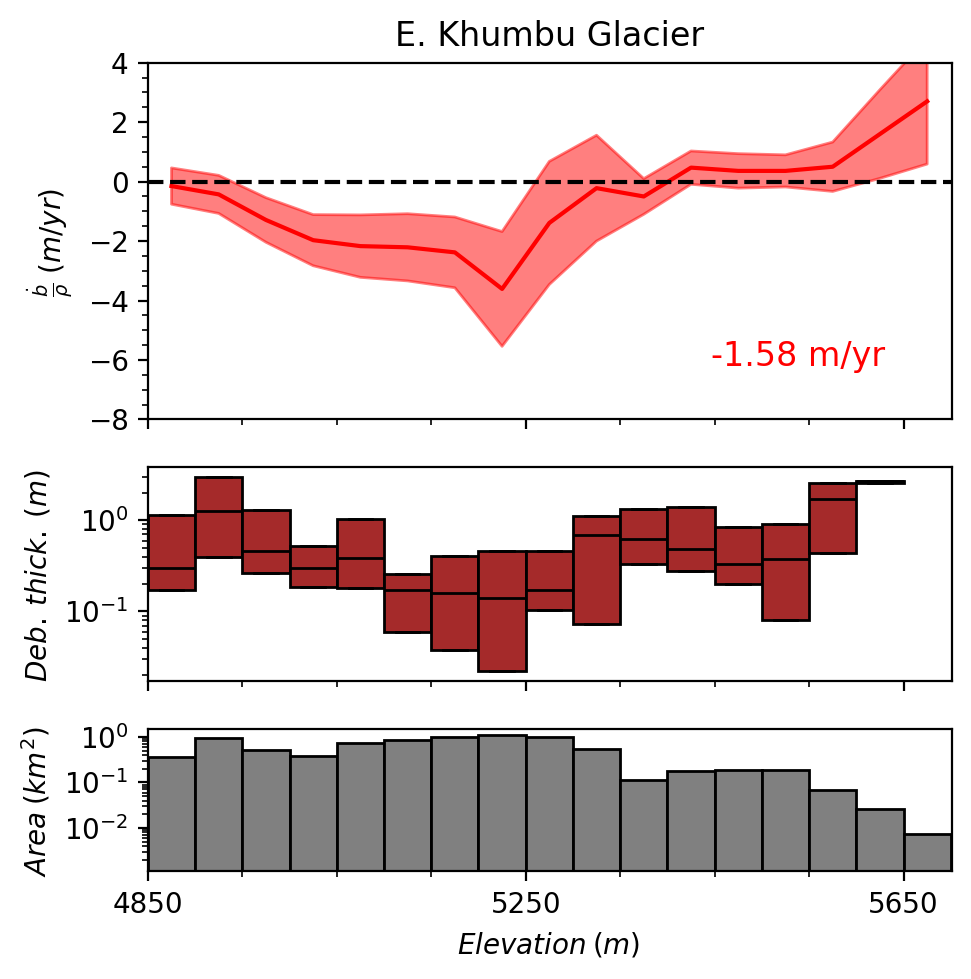

In [31]:
melt_df = pd.read_csv('Khumbu/SMB_data/khumbu_farinotti_2015-11-02_to_2016-10-25_altitudnal_meltstats.csv')
debris_box_plot = boxplot_stats_aggregator(melt_df)
#plot_glacier_meltcurve(melt_df,debris_box_plot,,ylim=(-14,10),xlim=(4800,5801))
old_title = 'Khumbu Glacier 2015-11-02 to 2016-10-25'
title = 'E. Khumbu Glacier'
f,ax = plot_glacier_meltcurve(melt_df,debris_box_plot,title,ylim=(-8,4),xlim=(4850,5701),log_scale=True)
print(ax[2].get_ylim())
print(ax[1].get_ylim())
f.savefig('/nobackup/sbhusha1/chapter2/figures/khumbu_profile_log_scale_no_lim.png',dpi=300,bbox_inches='tight',pad_inches=0.1)

(0.0011124606311300202, 3.2126363799438398)
(0.00013055020014235964, 4.038171275475809)


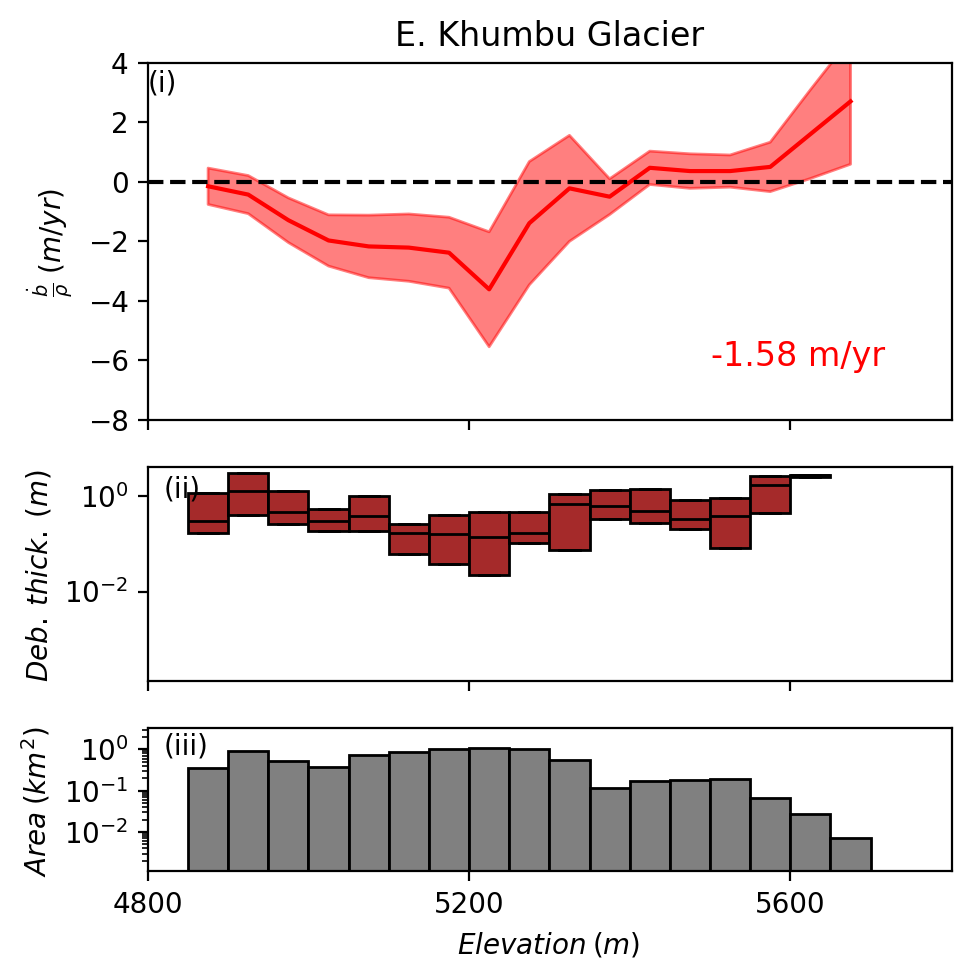

In [91]:
melt_df = pd.read_csv('Khumbu/SMB_data/khumbu_farinotti_2015-11-02_to_2016-10-25_altitudnal_meltstats.csv')
debris_box_plot = boxplot_stats_aggregator(melt_df)
#plot_glacier_meltcurve(melt_df,debris_box_plot,,ylim=(-14,10),xlim=(4800,5801))
old_title = 'Khumbu Glacier 2015-11-02 to 2016-10-25'
title = 'E. Khumbu Glacier'
f,ax = plot_glacier_meltcurve(melt_df,debris_box_plot,title,ylim=(-8,4),xlim=(4800,5801),log_scale=True,set_deb_area_lim=True)
print(ax[2].get_ylim())
print(ax[1].get_ylim())
f.savefig('/nobackup/sbhusha1/chapter2/figures/khumbu_profile_log_scale_common_lim.png',dpi=300,bbox_inches='tight',pad_inches=0.1)

## Imja Glacier

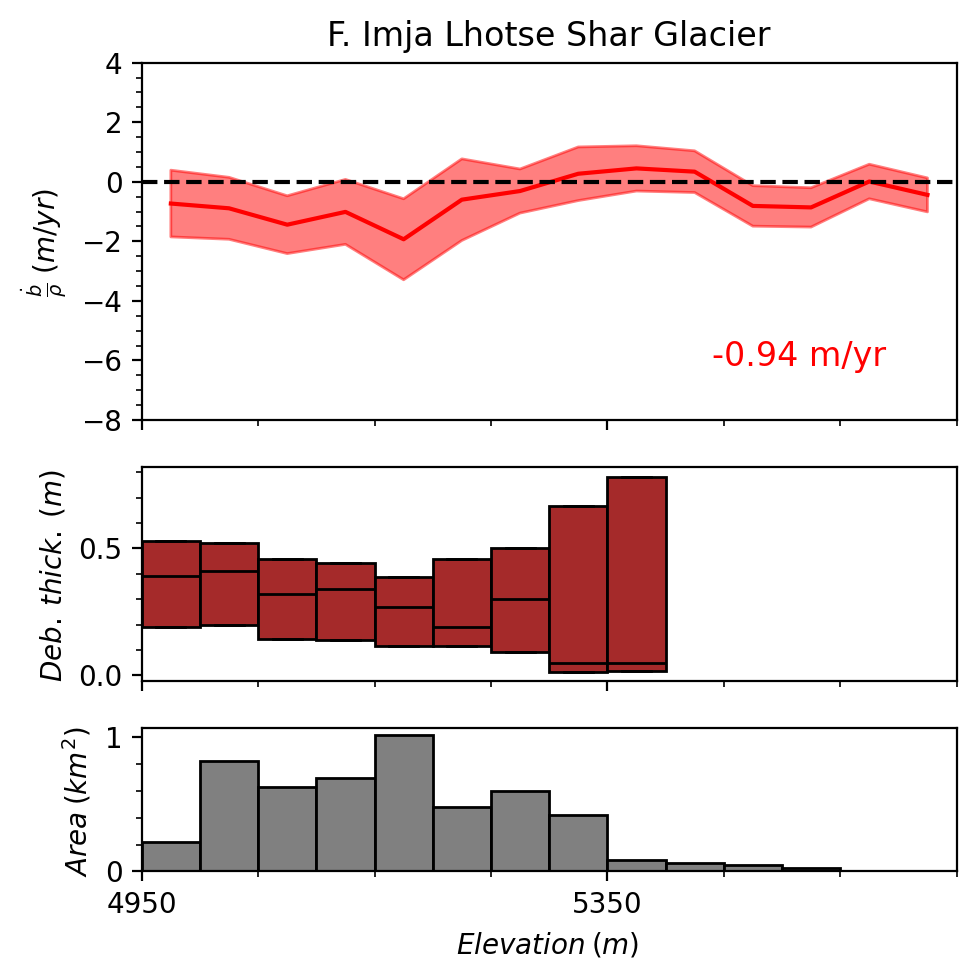

In [32]:
#melt_df = pd.read_csv(sorted(glob.glob('/nobackup/deshean/ps_velocity/imja/dem_dir/aligned_dems/hstest/quick_test/imja_farinotti_2015-10-02_to_2016-10-29_lag_smb_products/*melt*.csv'))[0])
melt_df = pd.read_csv('ImjaLhotseShar/SMB_data/imja_farinotti_2015-10-02_to_2016-10-29_altitudnal_meltstats.csv')
debris_box_plot = boxplot_stats_aggregator(melt_df)
old_title = 'Imja Lhotse Shar Glacier 2015-10-02 to 2016-10-29'
title = 'F. Imja Lhotse Shar Glacier'
f,ax = plot_glacier_meltcurve(melt_df,debris_box_plot,title,ylim=(-8,4),xlim=(4950,5650))
f.savefig('/nobackup/sbhusha1/chapter2/figures/imja_profile_normal_scale_no_lim.png',dpi=300,bbox_inches='tight',pad_inches=0.1)

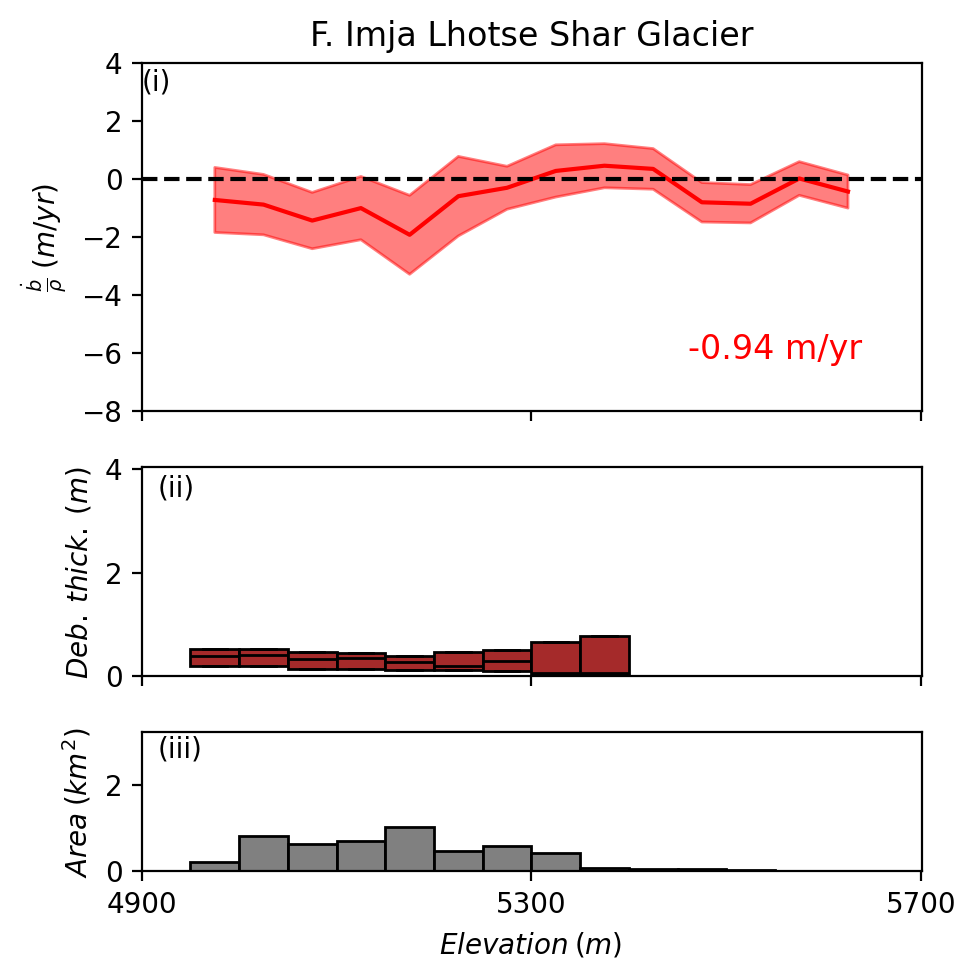

In [93]:
#melt_df = pd.read_csv(sorted(glob.glob('/nobackup/deshean/ps_velocity/imja/dem_dir/aligned_dems/hstest/quick_test/imja_farinotti_2015-10-02_to_2016-10-29_lag_smb_products/*melt*.csv'))[0])
melt_df = pd.read_csv('ImjaLhotseShar/SMB_data/imja_farinotti_2015-10-02_to_2016-10-29_altitudnal_meltstats.csv')
debris_box_plot = boxplot_stats_aggregator(melt_df)
old_title = 'Imja Lhotse Shar Glacier 2015-10-02 to 2016-10-29'
title = 'F. Imja Lhotse Shar Glacier'
f,ax = plot_glacier_meltcurve(melt_df,debris_box_plot,title,ylim=(-8,4),xlim=(4900,5701),set_deb_area_lim=True)
f.savefig('/nobackup/sbhusha1/chapter2/figures/imja_profile_normal_scale_common_lim.png',dpi=300,bbox_inches='tight',pad_inches=0.1)

(0.00013055020014235964, 1.5535724937896125)
(0.011918591749472964, 0.9539637773867227)


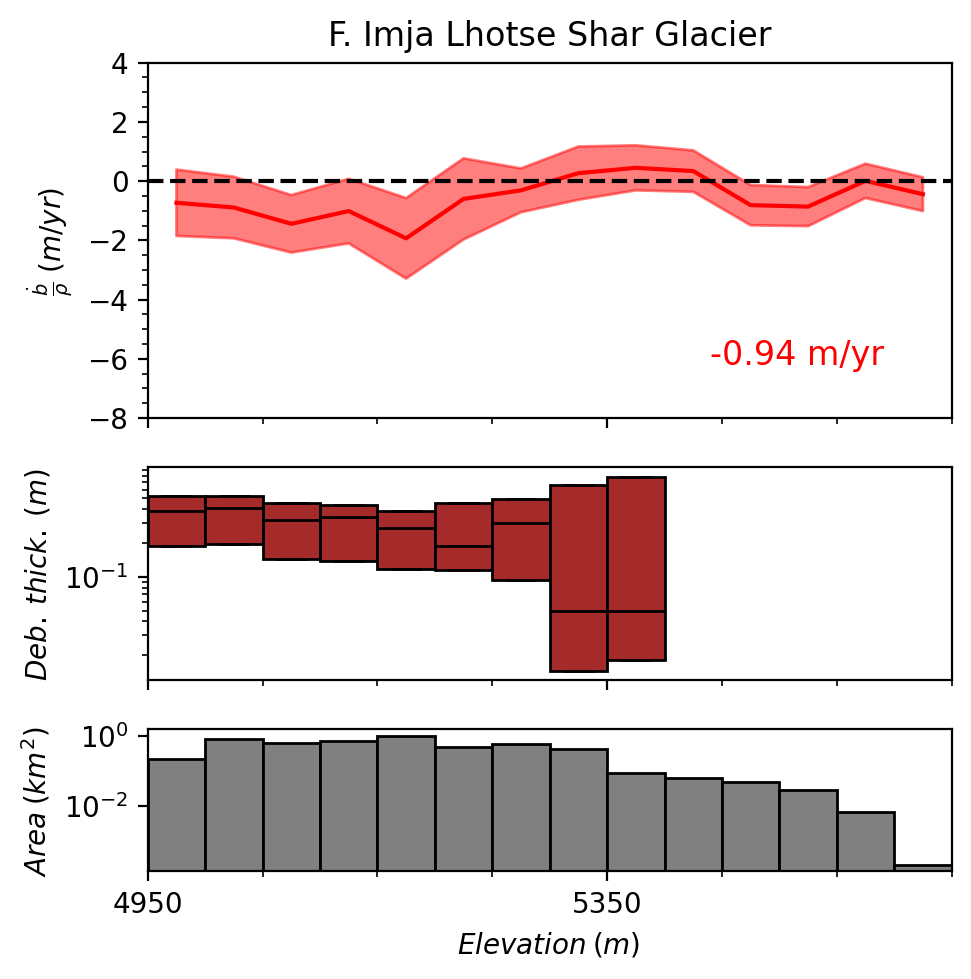

In [33]:
#melt_df = pd.read_csv(sorted(glob.glob('/nobackup/deshean/ps_velocity/imja/dem_dir/aligned_dems/hstest/quick_test/imja_farinotti_2015-10-02_to_2016-10-29_lag_smb_products/*melt*.csv'))[0])
melt_df = pd.read_csv('ImjaLhotseShar/SMB_data/imja_farinotti_2015-10-02_to_2016-10-29_altitudnal_meltstats.csv')
debris_box_plot = boxplot_stats_aggregator(melt_df)
old_title = 'Imja Lhotse Shar Glacier 2015-10-02 to 2016-10-29'
title = 'F. Imja Lhotse Shar Glacier'
f,ax = plot_glacier_meltcurve(melt_df,debris_box_plot,title,ylim=(-8,4),xlim=(4950,5650),log_scale=True)
print(ax[2].get_ylim())
print(ax[1].get_ylim())
f.savefig('/nobackup/sbhusha1/chapter2/figures/imja_profile_log_scale_no_lim.png',dpi=300,bbox_inches='tight',pad_inches=0.1)

(0.0011124606311300202, 3.2126363799438398)
(0.00013055020014235964, 4.038171275475809)


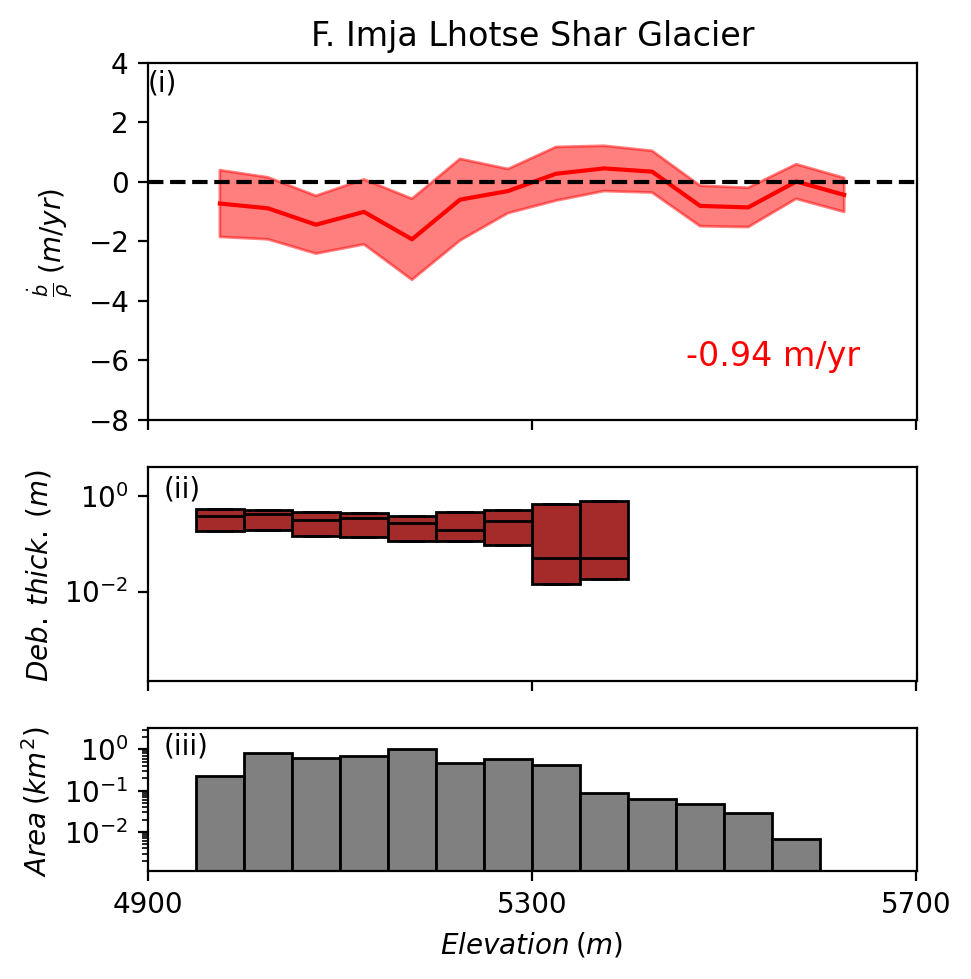

In [95]:
#melt_df = pd.read_csv(sorted(glob.glob('/nobackup/deshean/ps_velocity/imja/dem_dir/aligned_dems/hstest/quick_test/imja_farinotti_2015-10-02_to_2016-10-29_lag_smb_products/*melt*.csv'))[0])
melt_df = pd.read_csv('ImjaLhotseShar/SMB_data/imja_farinotti_2015-10-02_to_2016-10-29_altitudnal_meltstats.csv')
debris_box_plot = boxplot_stats_aggregator(melt_df)
old_title = 'Imja Lhotse Shar Glacier 2015-10-02 to 2016-10-29'
title = 'F. Imja Lhotse Shar Glacier'
f,ax = plot_glacier_meltcurve(melt_df,debris_box_plot,title,ylim=(-8,4),xlim=(4900,5701),log_scale=True,set_deb_area_lim=True)
print(ax[2].get_ylim())
print(ax[1].get_ylim())
f.savefig('/nobackup/sbhusha1/chapter2/figures/imja_profile_log_scale_common_lim.png',dpi=300,bbox_inches='tight',pad_inches=0.1)